<center> <img src = https://abohomanbangla.com/AbohomanAdminLogin/left_ad_img/logo-booking-com-png-booking-logo-logotype-3700.png alt="drawing" style="width:900px;"> </center>

# <center> Проект: Проверка и предсказание рейтинга отелей на Booking

In [603]:
#Импортируем все необходимые библиотеки

import pandas as pd
import numpy as np

#Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Импортируем специальный инструмент для разбивки  
from sklearn.model_selection import train_test_split 

#Импортируем библиотеку предупреждений об ошибках
import warnings
warnings.filterwarnings('ignore')

#Импортируем библиотеку для работы с кодировщиком
import category_encoders as ce

In [604]:
#Фиксируем рандомное число (RANDOM_SEED) для воспроизводимости результатов
RANDOM_SEED = 42

#Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

# 0. Постановка задачи 
Есть вероятность, что нечестные отели накручивают себе рейтинг. Необходимо построить модель, которая предсказывает рейтинг отеля для нахождения недобросовестных отелей.

# 1. Сбор и загрузка данных
Данные предоставлены в соревновании на Kaggle. Загружены в папку data.

* _hotels_train.csv_ - набор данных для обучения
* _hotels_test.csv_ - набор данных для оценки качества
* _submission.csv_ - файл сабмишна в нужном формате

## 1.1 Знакомство с данными

In [605]:
#Загружаем датафреймы
df_test = pd.read_csv('data/hotels_test.csv')
df_train = pd.read_csv('data/hotels_train.csv')
df_submission = pd.read_csv('data/submission.csv')

* _hotel_address_ - адрес отеля
* _review_date_ - дата, когда рецензент разместил соответствующий отзыв.
* _average_score_ - средний балл отеля, рассчитанный на основе последнего комментария за последний год
* _hotel_name_ - название отеля
* _reviewer_nationality_ - национальность рецензента
* _negative_review_ - отрицательный отзыв, который рецензент дал отелю.
* _review_total_negative_word_counts_ - общее количество слов в отрицательном отзыв
* _positive_review_ - положительный отзыв, который рецензент дал отелю
* _review_total_positive_word_counts_ - общее количество слов в положительном отзыве
* _reviewer_score_ - оценка, которую рецензент поставил отелю на основе своего опыта
* _total_number_of_reviews_reviewer_has_given_ - количество отзывов, * которые рецензенты дали в прошлом
* _total_number_of_reviews_ - общее количество действительных отзывов об отеле
* _tags_ - теги, которые рецензент дал отелю.
* _days_since_review_ - продолжительность между датой проверки и датой очистки
* _additional_number_of_scoring_ - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* _lat_ - широта отеля
* _lng_ - долгота отеля

In [606]:
display(df_test.head(3))
df_test.info()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [607]:
display(df_train.head(3))
df_train.info()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [608]:
display(df_submission.head(3))
df_submission.info()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [609]:
#Для корректной обработки признаков объединяем train и test в один датасет

#Помечаем данные train
df_train['sample'] = 1 

#Помечаем данные test
df_test['sample'] = 0 

#Так как в тесте нет значений reviewer_score, 
#заполняем его медианным значением из train
df_test['reviewer_score'] = df_train['reviewer_score'].median()

#Объединение
data = pd.concat([df_test, df_train])

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515738 entries, 0 to 386802
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 10  r

## 1.2 Вывод
Для корректной обработки признаков объединяем train и test в один датасет. В признаках lat и lng есть пропуски. Датасет состоит из данных с типами: object, int64, float64. Также имеется датасет submission с целевой переменной reviewer_score.

# 2. Очистка данных
Этап очистки необходим для поиска пропусков, дубликатов, а также аномалий в датасете. 

## 2.1 Заполнение пропусков в признаках _'lat'_ и _'lng'_

In [ ]:
#Создаем датафрейм с адресами, где нет координат
df_coord = data[data['lat'].isnull()].groupby('hotel_address').count()[['lat', 'lng']]

In [ ]:
#Формируем таблицу с координатами
coord = [[48.8399957, 2.3070823], 
           [48.8889127, 2.3309643], 
           [48.8753208, 2.3212033], 
           [41.391552, 2.1757053],
           [48.2208555, 16.3644228],
           [48.233592, 16.3434781],
           [48.2094054, 16.3512565],
           [48.2095525, 16.3492746],
           [48.1888183, 16.381591],
           [48.1868142, 16.418528],
           [41.3749946, 2.1102353],
           [48.219573, 16.2834034],
           [41.3832425, 2.1607609],
           [48.2458909, 16.3397395],
           [48.2135906, 16.3777195],
           [48.2168032, 16.357717],
           [48.220414, 16.3536299]]

In [ ]:
#Заносим данные в созданный датафрейм
for i in range(len(df_coord)):
    df_coord.iloc[i] = coord[i]
df_coord

,lat,lng
hotel_address,,
20 Rue De La Ga t 14th arr 75014 Paris France,48.839996,2.307082
23 Rue Damr mont 18th arr 75018 Paris France,48.888913,2.330964
4 rue de la P pini re 8th arr 75008 Paris France,48.875321,2.321203
Bail n 4 6 Eixample 08010 Barcelona Spain,41.391552,2.175705
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,48.220855,16.364423
Hasenauerstra e 12 19 D bling 1190 Vienna Austria,48.233592,16.343478
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria,48.209405,16.351257
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria,48.209553,16.349275
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria,48.188818,16.381591


In [ ]:
#Переносим данные в наш основной датафрейм
data = data.set_index('hotel_address')
data.update(df_coord)
data = data.reset_index()

## 3. Разбор признаков (EDA)

### Признак _'hotel_address'_
Виделим из него страну, a затем закодируем ее.

In [ ]:
#Извлекаем страну
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1])
#Исправляем название страны Kingdom, на United Kingdom
data.loc[data['hotel_country'] == 'Kingdom', 'hotel_country'] = 'United Kingdom'

data['hotel_country'].value_counts()

#Закодируем страны методом OneHotEncoding
encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True) 
type_bin = encoder.fit_transform(data['hotel_country'])
data = pd.concat([data, type_bin], axis=1)

#Удалим 'hotel_address' и ''hotel_country' так как больше нам не нужны
data = data.drop(['hotel_address', 'hotel_country'], axis = 1)

### Признак _'additional_number_of_scoring'_
Удаляем данный признак из-за сильной корреляции с признаком 'total_number_of_reviews'

In [ ]:
data = data.drop(['additional_number_of_scoring'], axis = 1)

### Признак _'review_date'_
Выделим из признака 'review_date' месяц в который отзыв был оставлен. Далее создадим функцию для определения сезона, и закодируем данный признак.

In [ ]:
#Преобразуем review_date в формат datetime и выделяем из даты месяц и год
data['review_date'] = pd.to_datetime(data['review_date'], dayfirst=True)

data['month'] = data['review_date'].dt.month

data['year'] = data['review_date'].dt.year

#Удаляем признак review_date так как он нам больше не понадобится
data = data.drop(['review_date'], axis = 1)

### Признак _'average_score'_
Признак среднего балла отеля. Значимый признак, оставляем без изменений.

### Признак _'hotel_name'_
Признак использоваться мною не будет, поэтому удаляем его.

In [ ]:
#Удаляем признак hotel_name
data = data.drop(['hotel_name'], axis = 1)

### Признак _'reviewer_nationality'_
Используя метод бинарного кодирования закодируем данный признак.


In [ ]:
#Закодируем данный признак методом бинарного кодирования 
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

#Удалим признак reviewer_nationality, так как больше нам не нужен
data = data.drop(['reviewer_nationality'], axis = 1)

### Признак _'tags'_
Определяем длину tags и используя метод бинарного кодирования закодируем данный признак.

In [ ]:
#Определим длинну полную длину списков в столбце tags
data['tags_n'] = data['tags'].map(len)

#Разобьем списки tags на отдельные теги
data['tags_split'] = data['tags'].apply(lambda x: x[3:-3].split(" ', ' "))
#Определим колиечство отдельных тегов в каждой строке признака tags
data['tags_n_split'] = data['tags_split'].map(len)


#Извлекаем информацию из признака tags
data = data.explode(['tags'])
data.fillna('', inplace = True)

#Закодируем данный признак методом бинарного кодирования 
bin_encoder = ce.BinaryEncoder(cols=['tags'])
type_bin = bin_encoder.fit_transform(data['tags'])
data = pd.concat([data, type_bin], axis=1)

#Удалим признак tags и tags_split, так как больше нам не нужен
data = data.drop(['tags', 'tags_split'], axis = 1)

### Признаки _'negative_review'_ и _'positive_review'_
Определяем наличие или отсутсвие позитивных и негативных отзывов.
Далее определяем общее впечатление об отеле.

In [ ]:
#Создадим функцию, определяющую есть негативный или позитивный отзыв
def get_negative(n):
    if n == 'No Negative':
        n = 0
    else:
        n = 1
    return n

def get_positive(p):
    if p == 'No Positive':
        p = 0
    else:
        p = 1
    return p

data['negative_review'] = data['negative_review'].apply(get_negative)
data['positive_review'] = data['positive_review'].apply(get_positive)

#Создадим функцию которая определяет общие впечатления об отеле

def  get_the_overall_impression(negative_review, positive_review):
    if negative_review == 1 and positive_review == 0:
        return 0
    elif negative_review == 0 and positive_review == 1:
        return 1
    else:
        return 0.5

data['the_overall_impression'] = data.apply(
    lambda row: get_the_overall_impression(row['negative_review'], row['positive_review']),
    axis=1
)

#Удалим признаки negative_review и positive_review, так как больше они не нужны
data = data.drop(['negative_review', 'positive_review'], axis = 1)


### Признак _'days_since_review'_
Очистим признак days_since_review от текста

In [ ]:
#Очищаем days_since_review от текста 
data['days_since_review'] = data['days_since_review'].str.extract('(\d+)').astype(int)

# 4. Этап моделирования

<Axes: >

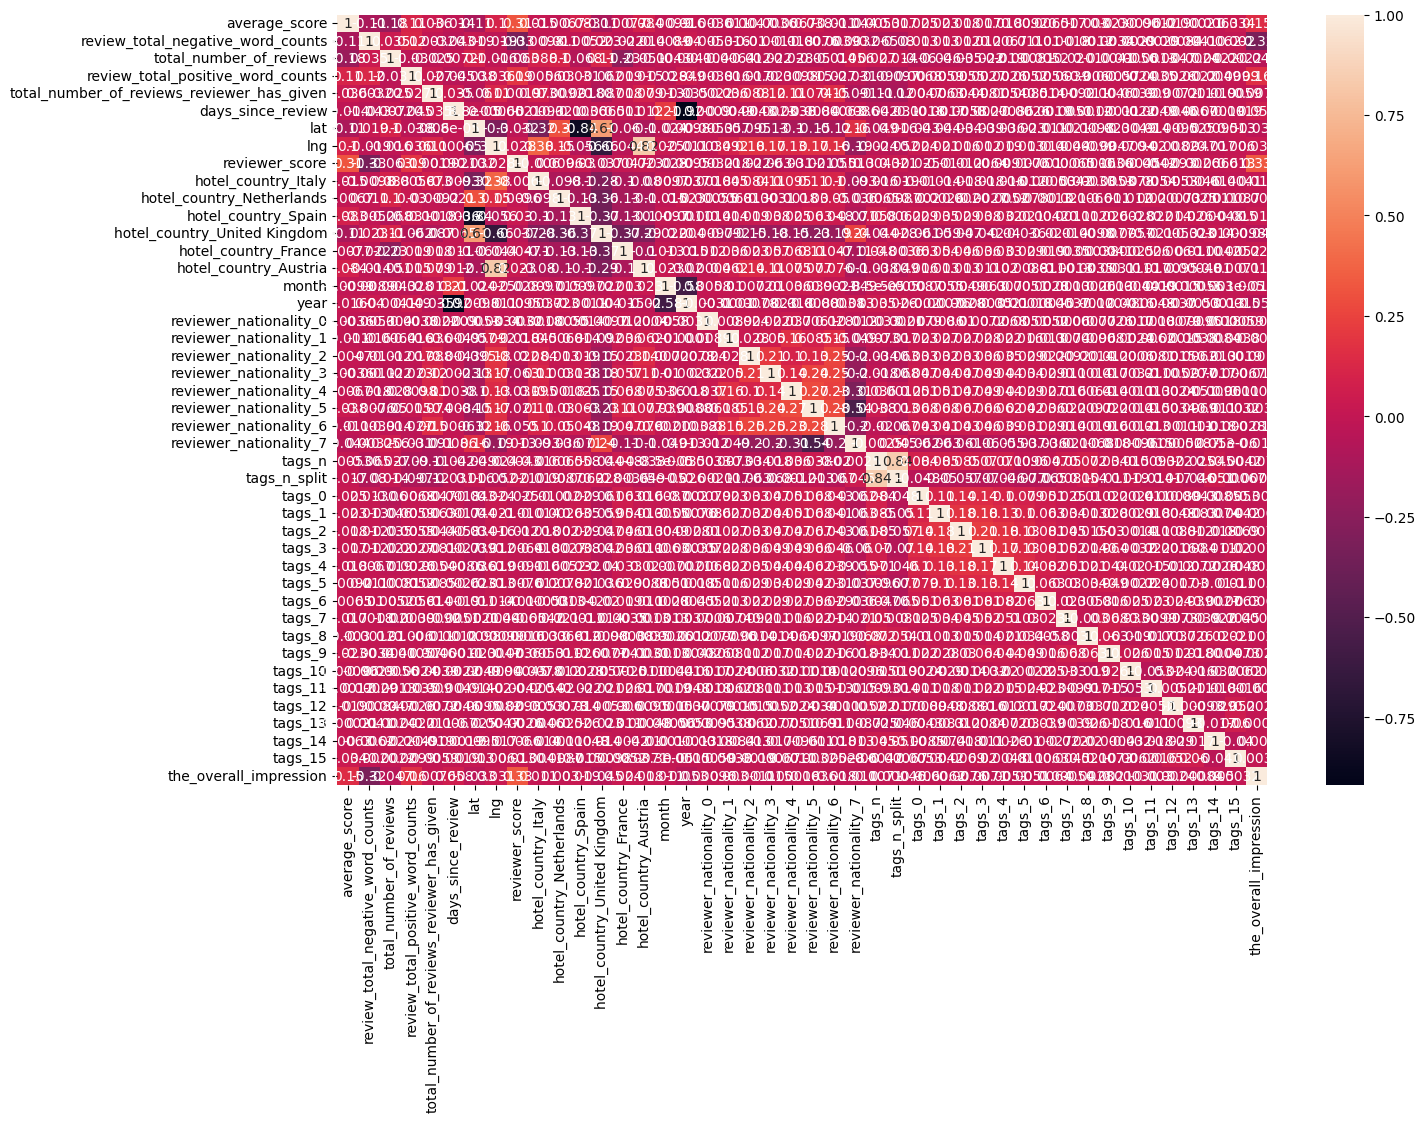

In [ ]:
#Создадим тепловую карту
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515738 entries, 0 to 515737
Data columns (total 45 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   days_since_review                           515738 non-null  int32  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 10  h

In [ ]:
#Выделим тестовую часть и тренировочную
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score'] 

display(y)

128935    10.0
128936     6.3
128937     7.5
128938    10.0
128939     9.6
          ... 
515733     8.8
515734     9.2
515735     8.3
515736     9.2
515737     8.8
Name: reviewer_score, Length: 386803, dtype: float64

In [ ]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 20% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [ ]:
#Проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 44), (386803, 44), (386803, 43), (309442, 43), (77361, 43))

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
#Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
#Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

#Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
#Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    2.6s finished


In [ ]:
#Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
#Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', (np.abs(y_test - y_pred) / y_test).mean())

MAPE: 0.13566798460886087


<Axes: >

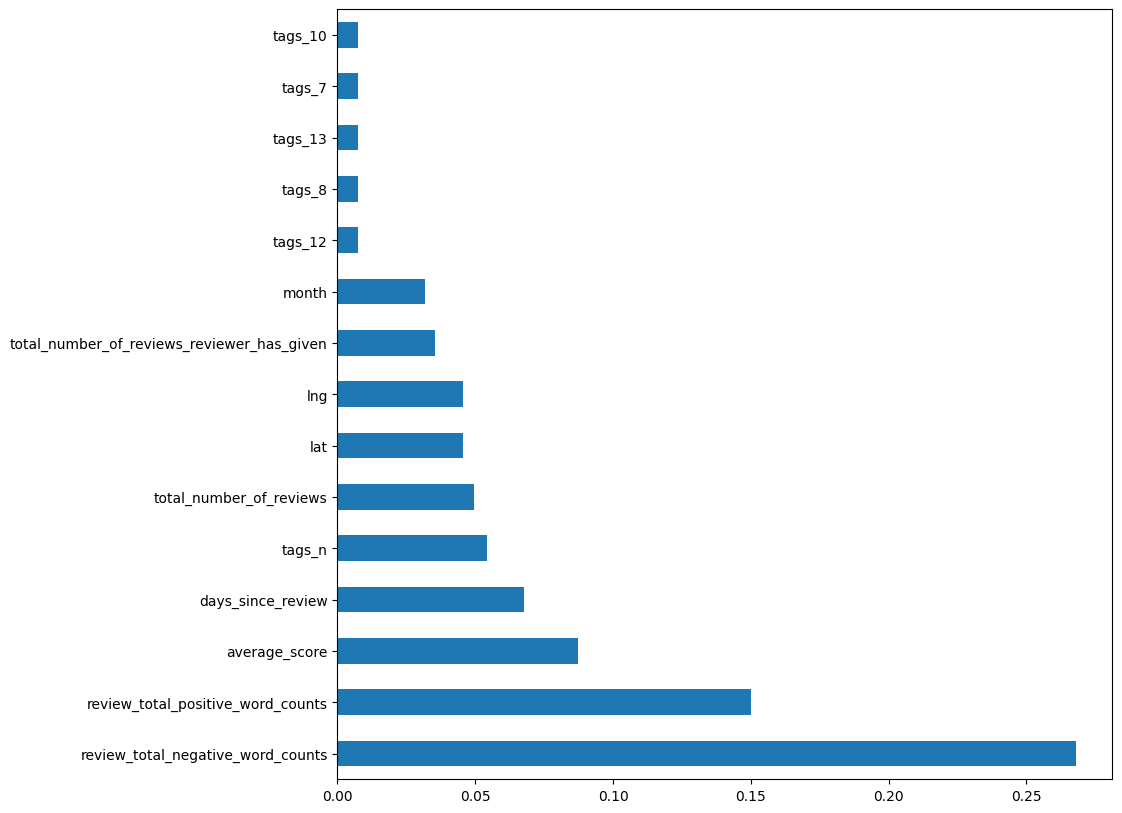

In [ ]:
#В RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
#Посмотрим на структуру test_data
display(test_data.head(5))

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,hotel_country_Italy,...,tags_7,tags_8,tags_9,tags_10,tags_11,tags_12,tags_13,tags_14,tags_15,the_overall_impression
0,8.1,52,16670,62,1,13,45.533137,9.171102,8.8,1,...,0,0,0,0,0,0,0,0,1,0.5
1,8.6,10,5018,0,7,234,52.385649,4.834443,8.8,0,...,0,0,0,0,0,0,0,1,0,0.0
2,8.3,3,351,5,15,616,41.393192,2.161520,8.8,0,...,0,0,0,0,0,0,0,1,1,0.5
3,9.1,0,1543,27,9,656,45.479888,9.196298,8.8,1,...,0,0,0,0,0,0,1,0,0,1.0
4,9.1,0,4687,7,2,444,52.370545,4.888644,8.8,0,...,0,0,0,0,0,0,1,0,1,1.0


In [ ]:
#Удалим из test_data столбец reviewer_score
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
#Итоговое предсказание на тестовых данных датасета
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.4s finished


In [ ]:
#Выведем полученный результат итогового предсказания
display(predict_submission)

array([8.733, 7.075, 8.082, ..., 8.358, 9.602, 6.898])

In [ ]:
#Заменим значения reviewer_score в df_submission на предсказанные
df_submission['reviewer_score'] = predict_submission
display(df_submission.head(5))

#Создадим csv-файл submission
df_submission.to_csv('data/submission_5.csv', index=False)


,reviewer_score,id
0,8.733,488440
1,7.075,274649
2,8.082,374688
3,9.625,404352
4,9.718,451596


# 5. Вывод

В результате проделанной работы, были разобраны и проанализированы исходные данные. Созданы новые признаки на базе данных признаков. Обучена и построена ML модель. Создан финальный csv-файл submission.